# Analysis of single mutant effect on biodistribution  in mice

Analysis includes:
- correlation of mouse replicates 
- PCA of selection values across tissues 
- K-Means to determine mutation clusters
- Validation comparison 

In [1]:
import os 
import sys 

import pandas as pd 
pd_idx = pd.IndexSlice
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import scipy.stats as stats

import common 

sys.path.append('../x01_process_data/')
import x02_load_dataframes
import x03_compute_selections

sys.path.append('../settings/')
from paths_new import DATAFRAMES_DIR
from paths_new import FIGURES_DIR
from paths_new import DESIRED_AA_ORD
from paths_new import LOOKUP_DF
from common_functions import codon_to_aa_selector
from paper_settings import save_fig
from paper_settings import PAPER_PRESET
from paper_settings import PAPER_FONTSIZE

%reload_ext autoreload
%autoreload 2

set_2_colors = sns.color_palette("muted")
sns.set(**PAPER_PRESET)
font_size=PAPER_FONTSIZE
tissue_grabber = ['blood', 'heart', 'kidney', 'lung', 'liver','spleen']

### load in mouse and packaging data 

In [2]:
package_counts = x02_load_dataframes.load_packaging_df()
package_counts.sort_index(inplace=True)
mouse_counts = x02_load_dataframes.load_mouse_df()

In [3]:
mouse_counts.head()

organ                                                                                               blood  \
virus                                                                                                   1   
mouse                                                                                                   1   
replicate                                                                                               1   
prep                                                                                               qiagen   
lib_num                                                                                                97   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                       
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT   70.0   
                                                                              CTGTGAGTGTGAGAGACACT  101.0   
                                                               TAG   *-TAG    CAGAGACAGAGTCTGTCACT   11.0   
                                                                              CTCTCACACAGTGAGTCTGA   10.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG  114.0   

organ                                                                                                      \
virus                                                                                                       
mouse                                                                                                   2   
replicate                                                                                               1   
prep                                                                                               qiagen   
lib_num                                                                                                98   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                       
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT   70.0   
                                                                              CTGTGAGTGTGAGAGACACT   64.0   
                                                               TAG   *-TAG    CAGAGACAGAGTCTGTCACT   19.0   
                                                                              CTCTCACACAGTGAGTCTGA   12.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG  112.0   

organ                                                                                                      \
virus                                                                                                       
mouse                                                                                                   3   
replicate                                                                                               1   
prep                                                                                               qiagen   
lib_num                                                                                                99   
abs_pos tile_num aa is_wt_aa is_wt_codon wt_bc lib_type enzyme codon aa-codon barcode                       
1.0     0.0      *  0        0           0     sub      bbsi   TAA   *-TAA    CACTGTCACACACTGACACT   57.0   
                                                                              CTGTGAGTGTGAGAGACACT   62.0   
                                                               TAG   *-TAG    CAGAGACAGAGTCTGTCACT    8.0   
                                                                              CTCTCACACAGTGAGTCTGA    8.0   
                                                               TGA   *-TGA    ACACTGTCTCTGTCAGACAG   89.0   

organ                                                                    

### filter out mutations with low counts and compute selection for mouse data

In [4]:
mouse_counts_filtered = mouse_counts.where(
        (mouse_counts > 10) & (mouse_counts <31000), np.nan)

package_selection = x03_compute_selections.compute_packaging_selection(package_counts, level='aa')

new_mouse_selection = x03_compute_selections.compute_mouse_selections(
        package_counts=package_counts, 
        mouse_counts=mouse_counts_filtered, 
        wt_norm=True,drop=True,
        drop_tile=False,
        return_freq=False)

mouse_aa_selection =  new_mouse_selection['aa_selection']
mouse_aa_sel_package_filtered = codon_to_aa_selector(
    package_selection[package_selection[('CMV','0')]>.5], mouse_aa_selection)
mouse_aa_sel_package_filtered.head()

/home/ubuntu/repos/AAV_fitness_landscape/venv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:879: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


['abs_pos', 'aa', 'lib_type']


/home/ubuntu/repos/AAV_fitness_landscape/venv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (6 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/ubuntu/repos/AAV_fitness_landscape/venv/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


organ                         blood                                   liver  \
virus                             1                                       1   
mouse                             1         2         3         4         1   
replicate                         1         1         1         1         1   
prep                         qiagen    qiagen    qiagen    qiagen    qiagen   
lib_num                          97        98        99       100         9   
abs_pos aa wt_bc lib_type                                                     
1.0     M  1     sub       0.979467  1.001131  1.008093  1.015803  0.356283   
1.5     A  0     ins       0.851688  0.911220  0.985651  0.957245  1.485345   
        G  0     ins       1.064947  1.082238  1.248799  1.087336       NaN   
2.0     A  0     sub       0.388537  0.552416  0.590746  1.221429       NaN   
2.5     A  0     ins       1.028298  1.098367  1.017820  0.999689  0.267847   

organ                                                      spleen            \
virus                                                           1             
mouse                             2         3         4         1         2   
replicate                         1         1         1         1         1   
prep                         qiagen    qiagen    qiagen    qiagen    qiagen   
lib_num                          10        11        12         1         2   
abs_pos aa wt_bc lib_type                                                     
1.0     M  1     sub       0.658451  0.896220  1.092260  0.905939  0.988181   
1.5     A  0     ins            NaN  1.425935  0.639529  0.873168  0.921540   
        G  0     ins       1.897374  1.083420  0.665003  0.886194  0.906433   
2.0     A  0     sub            NaN       NaN  0.711105  0.509681  1.262808   
2.5     A  0     ins       1.734873  1.280167  0.573528  1.022857  0.887595   

organ                     ...     kidney      lung                      \
virus                     ...          2         2                       
mouse                     ...          2         1                       
replicate                 ...          4         0         1         2   
prep                      ...       mini        GP      mini      mini   
lib_num                   ...         19        31        28        29   
abs_pos aa wt_bc lib_type ...                                            
1.0     M  1     sub      ...   0.968157  1.001215  0.929890  0.989829   
1.5     A  0     ins      ...   0.812046  0.600955  0.879422  0.670771   
        G  0     ins      ...   1.137538  0.812873  0.523290  0.682510   
2.0     A  0     sub      ...   0.564716  0.482100  0.261691  0.104977   
2.5     A  0     ins      ...   0.911151  0.871157  0.689805  0.782754   

organ                                                                        \
virus                                                                         
mouse                                       2                                 
replicate                         3         0         1         2         3   
prep                           mini        GP      mini      mini      mini   
lib_num                          30        36        32        33        34   
abs_pos aa wt_bc lib_type                                                     
1.0     M  1     sub       1.060381  1.156421  1.021424  1.043092  1.017331   
1.5     A  0     ins       0.804960  0.637138  0.670797  0.585228  0.658230   
        G  0     ins       0.935368  0.805495  0.520995  0.768576  0.667615   
2.0     A  0     sub       0.328843  1.520199  0.378239  0.170513  0.401062   
2.5     A  0     ins       0.801642  0.700359  0.648466  0.829416  0.803694   

organ                           
virus                           
mouse                           
replicate                    4  
prep                      mini  
lib_num                     35  
abs_pos aa wt_bc lib_type       
1.0     M  1     sub       NaN  


### pearson correlation for selection across all mouse replicates 

In [5]:
mini_tissues = mouse_aa_sel_package_filtered.loc[:,pd_idx[:,:,:,:,'mini']]
qiagen_tissues = mouse_aa_sel_package_filtered.loc[:,pd_idx[['blood','liver','spleen'],:,:,:]]
mouse_data_for_corr_plot = pd.concat([mini_tissues, qiagen_tissues], axis=1)

In [6]:
mouse_aa_sel_filtered_corr = mouse_data_for_corr_plot.corr()
mouse_aa_sel_filtered_corr.columns = mouse_aa_sel_filtered_corr.columns.droplevel([3,4,5]) 
mouse_aa_sel_filtered_corr.index = mouse_aa_sel_filtered_corr.index.droplevel([3,4,5]) 
mouse_aa_sel_filtered_corr.sort_index(axis=0,inplace=True)
mouse_aa_sel_filtered_corr.sort_index(axis=1,inplace=True)
mouse_aa_sel_filtered_corr.dropna(how='all',inplace=True)
mouse_aa_sel_filtered_corr.dropna(axis=1,how='all',inplace=True)

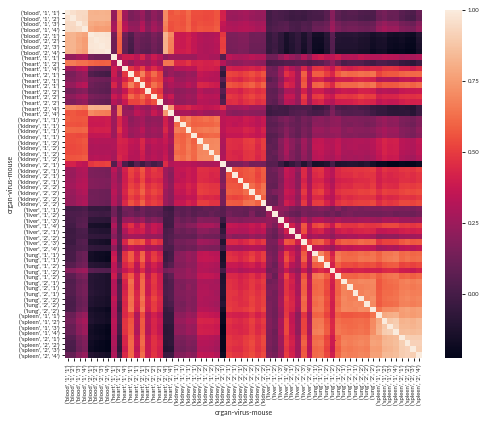

In [7]:
fig, ax = plt.subplots(figsize=(5*1.6,4*1.6))

sns.heatmap(mouse_aa_sel_filtered_corr,
            xticklabels=mouse_aa_sel_filtered_corr.columns,
           yticklabels=mouse_aa_sel_filtered_corr.index,ax=ax)
# save_fig(fig, 'a03s_revisions_PO29a_mouse_replicates_corr_heatmap.pdf')

### pearson within a tissue for all samples 

In [8]:
mouse_aa_sel_filtered_corr_cop = mouse_data_for_corr_plot.corr()
mouse_aa_sel_filtered_corr_cop = mouse_aa_sel_filtered_corr_cop.rename_axis(
    [None,None,None,None,None,None]).rename_axis( [None,None,None,None,None,None], axis=1)

mouse_corr_flatten_df = mouse_aa_sel_filtered_corr_cop.stack(list(range(0,6))).reset_index()[['level_0','level_6',0]]
# mouse_corr_flatten_df

mouse_aa_sel_filtered_corr_cop.head()
mouse_corr_intra_tissue =  pd.DataFrame()

for tissue in tissue_grabber:
    df = mouse_corr_flatten_df.query("level_0==@tissue").query("level_6==@tissue")
    mouse_corr_intra_tissue = pd.concat([mouse_corr_intra_tissue, df])
    
mouse_corr_intra_tissue.drop_duplicates(inplace=True)
mouse_corr_intra_tissue.head()

,level_0,level_6,0
2356,blood,blood,1.000000
2357,blood,blood,0.963477
2358,blood,blood,0.942001
2359,blood,blood,0.937798
2360,blood,blood,0.821809


Text(0,0.5,'Pearson R')

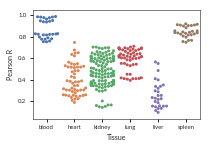

In [9]:
fig,ax = plt.subplots(figsize=[3,2])
sns.swarmplot(x='level_0', y=0, data=mouse_corr_intra_tissue[mouse_corr_intra_tissue[0]<1], size=3)
ax.set_xlabel('Tissue')
ax.set_ylabel('Pearson R')
# save_fig(fig, 'a03_revisions_x05_intratissue_corr_swarm.pdf')

### process data for pca
- take the median aa measurement for each tissue across all replicates
- remove infinity values
- filter selection to only get mutations which contain at least one deviant from WT selection value across all tissues

In [10]:
mouse_data_for_pca = mouse_data_for_corr_plot.T.groupby(level='organ').median().replace(
        [np.inf,-np.inf,0],np.nan).apply(np.log2).T.dropna()
mouse_data_for_pca_selection_filtered = mouse_data_for_pca[
    ((mouse_data_for_pca>1).any(1)) | ((mouse_data_for_pca<-1).any(1))]
mouse_data_for_pca.head()

organ                         blood     heart    kidney     liver      lung  \
abs_pos aa wt_bc lib_type                                                     
1.0     M  1     sub      -0.004536 -0.041369  0.017231 -0.273577  0.024789   
1.5     A  0     ins      -0.041792 -0.010272 -0.203204  0.016588 -0.313011   
        G  0     ins       0.288646 -0.132954 -0.314006 -0.172299 -0.551078   
2.0     A  0     sub      -0.650473 -0.546251 -0.511453 -1.942433 -1.402631   
2.5     A  0     ins      -0.005815 -0.160016 -0.061207 -0.698470 -0.318969   

organ                        spleen  
abs_pos aa wt_bc lib_type            
1.0     M  1     sub      -0.066456  
1.5     A  0     ins      -0.143360  
        G  0     ins      -0.122369  
2.0     A  0     sub      -0.401723  
2.5     A  0     ins      -0.117321

### correlation of median AA selection value across tissues

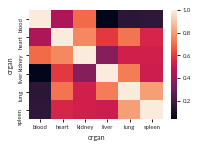

In [11]:
fig,ax = plt.subplots(figsize=[3,2])

sns.heatmap(mouse_data_for_pca_selection_filtered.corr(),ax=ax)

### compute PCA 

In [12]:
mouse_data_for_pca.shape

(7267, 6)

In [13]:
pca = PCA()
# pca_fit_best_tissues = pca.fit_transform(mouse_data_for_pca)
pca_fit_best_tissues = pca.fit_transform(mouse_data_for_pca_selection_filtered)


pca.explained_variance_ratio_

array([ 0.58092162,  0.2576817 ,  0.08672888,  0.03451919,  0.02704102,
        0.0131076 ])

In [14]:
pca_fit_best_tissues.shape

(2007, 6)

### generate dataframe of component values

In [15]:
pca_df = pd.DataFrame(pca_fit_best_tissues * -1, index=mouse_data_for_pca_selection_filtered.index)

print (pca_df.shape)
pca_df.head()

(2007, 6)


0         1         2         3         4  \
abs_pos aa wt_bc lib_type                                                     
2.0     A  0     sub       1.001602  0.119837  1.064891 -0.142870  0.110609   
10.0    T  0     sub       2.454055 -0.369599  0.809465  0.012530 -0.211280   
13.0    C  0     sub       2.688441 -0.216320  0.719888  0.132583 -0.135554   
19.0    E  0     sub       2.656961 -0.425986  0.815969  0.021397 -0.315456   
        S  0     sub       2.746411 -0.167938  0.816788  0.081451 -0.294462   

                                  5  
abs_pos aa wt_bc lib_type            
2.0     A  0     sub       0.162696  
10.0    T  0     sub       0.182861  
13.0    C  0     sub      -0.026570  
19.0    E  0     sub       0.071424  
        S  0     sub      -0.042492

### join component values with selection for plotting 

In [16]:
pca_selection_joined = pca_df.join(mouse_data_for_pca_selection_filtered)

In [17]:
pos_list = [str(x) for x in (list(pca_selection_joined.index.get_level_values(0)))]

### K-means to determine clusters 

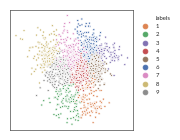

In [18]:
kmean_1 =KMeans(n_clusters=9, random_state=0).fit(pca_df)

label_dict = {0:3, 1:0,2:0,3:9, 4:2,5:0,6:0,7:0,8:1}
def relabel(x):
    return label_dict[x]

pca_df_kmeans = pca_df.copy()
pca_df_kmeans['labels'] = kmean_1.labels_
pca_df_kmeans

label_dict = {0:5, 1:8,2:4,3:9, 4:1,5:2,6:6,7:7,8:3}
def relabel(x):
    return label_dict[x]

pca_df_kmeans['labels'] = pca_df_kmeans['labels'].apply(relabel)

# plt.scatter(pca_df_kmeans[0],pca_df_kmeans[1],c=pca_df_kmeans['labels'])
fig,ax = plt.subplots(figsize=[2.2,2.2])
sns.scatterplot(
    pca_df_kmeans[0] ,pca_df_kmeans[1],s=5,lw=0,
    alpha=1, hue=pca_df_kmeans['labels'], 
    palette=[sns.color_palette('deep', 9)[i] for i in (1,2,4,3,5,0,6,8,7)],ax=ax)
# ax.axes('off')

ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend( loc=1, frameon=False, bbox_to_anchor=[1.35,1])

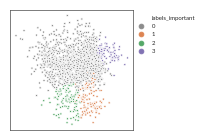

In [19]:
label_dict = {9:0,1:1,2:2, 3:3, 4:0,5:0,6:0,7:0,8:0}

pca_df_kmeans['labels_important'] = pca_df_kmeans['labels'].apply(relabel)

# plt.scatter(pca_df_kmeans[0],pca_df_kmeans[1],c=pca_df_kmeans['labels'])
fig,ax = plt.subplots(figsize=[2.2,2.2])
sns.scatterplot(
    pca_df_kmeans[0],pca_df_kmeans[1],s=5,lw=0.05,
    alpha=1, hue=pca_df_kmeans['labels_important'], 
    palette=[sns.color_palette('deep', 9)[i] for i in (7,1,2,4)] ,ax=ax)
# ax.axes('off')

ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend( loc=1, frameon=False, bbox_to_anchor=[1.55,1])

### selection values for all clusters identified with K-means

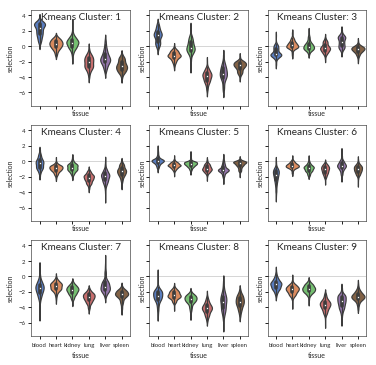

In [20]:
pca_kmeans_selection = pca_df_kmeans.join(mouse_data_for_pca_selection_filtered)

pca_kmeans_selection
fig, axes = plt.subplots(ncols=3,nrows=3, sharex=True,sharey=True,figsize=[6,6] )
kmeans=9
for ax, kmeans in zip(axes.flatten(), range(1,11)):

    kmeans_melted = pca_kmeans_selection[pca_kmeans_selection['labels'] == kmeans].melt(value_vars=['blood', 'liver', 'spleen','lung', 'heart', 'kidney'], var_name= 'tissue', 
                                value_name='selection')
    kmeans_melted
    sns.violinplot(x='tissue', y='selection', data=kmeans_melted,
                order=tissue_grabber,palette = sns.color_palette("muted", 6), errwidth=1,ax=ax )
    ax.text(.5,.9,'Kmeans Cluster: %s' % kmeans,
        horizontalalignment='center',
        transform=ax.transAxes)
    ax.set_yticks([0], minor=True)
    ax.yaxis.grid(which='minor')

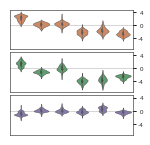

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3,sharex=True,sharey=True, figsize=[2.2,2.3],gridspec_kw = {"hspace":0.09})

kmeans_melted_8 = pca_kmeans_selection[pca_kmeans_selection['labels'] == 1].\
    melt(value_vars=['blood', 'liver', 'spleen','lung', 'heart', 'kidney'], var_name= 'tissue', 
                            value_name='selection')

sns.violinplot(x='tissue', y='selection', data=kmeans_melted_8,linewidth=.5,
            order=tissue_grabber,color=[sns.color_palette('deep', 9)[i] for i in (1,2,4)][0], errwidth=1,ax=ax1 )

kmeans_melted_4 = pca_kmeans_selection[pca_kmeans_selection['labels'] == 2].\
    melt(value_vars=['blood', 'liver', 'spleen','lung', 'heart', 'kidney'], var_name= 'tissue', 
                            value_name='selection')
sns.violinplot(x='tissue', y='selection', data=kmeans_melted_4,linewidth=.5,
            order=tissue_grabber,color = [sns.color_palette('deep', 9)[i] for i in (1,2,4)][1], errwidth=1,ax=ax2 )

kmeans_melted_0 = pca_kmeans_selection[pca_kmeans_selection['labels'] == 3].\
    melt(value_vars=['blood', 'liver', 'spleen','lung', 'heart', 'kidney'], var_name= 'tissue', 
                            value_name='selection')
sns.violinplot(x='tissue', y='selection', data=kmeans_melted_0,linewidth=.5,
            order=tissue_grabber,color=[sns.color_palette('deep', 9)[i] for i in (1,2,4)][2], errwidth=1,ax=ax3 )

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_yticks([-4,0,4])
    ax.set_yticks([0], minor=True)
    ax.yaxis.grid(which='minor')
    ax.set_ylabel('')
    ax.yaxis.tick_right()
#     ax.grid(axis='y')
    ax.tick_params(length=3,pad=7)
    ax.set_yticklabels([-4,0,4], ha='right')

### approximate K-means location (circles) with tissue selection values 

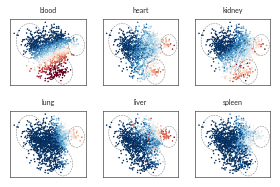

In [22]:
c1_coord = (4.8,.82)
c1_rad = 1.7
# c2_coord = (2.3,-3.5)
c2_coord = (2,-3.5)
c2_rad=2
c3_coord = (-5,1.5)
c3_rad = 2.8
c4_coord = (-1,-4.5)
c4_rad = 1

pca_selection_joined = pca_df.join(mouse_data_for_pca_selection_filtered)

fig, axes = plt.subplots(ncols=3,nrows=2, sharex=True,sharey=True,figsize=[4,2.7] )
# fig, axes = plt.subplots(ncols=3,nrows=2, sharex=True,sharey=True,figsize=[10,5] )


for ax, tissue in zip(axes.flatten(), tissue_grabber):
    ax.scatter(pca_selection_joined[0], pca_selection_joined[1], c=pca_selection_joined[tissue],
            cmap='RdBu_r',alpha=1,vmin=-2, vmax=2,s=.5)
    ax.set_title(tissue)

    c1 = plt.Circle(c1_coord,c1_rad, color=None,alpha=.5, ec='black', fc='none',ls='dashed',lw=.5)
    c2 = plt.Circle(c2_coord,c2_rad, color=None,alpha=.5, ec='black', fc='none',ls='dashed',lw=.5)
    c3 = plt.Circle(c3_coord,c3_rad, color=None,alpha=.5, ec='black', fc='none',ls='dashed',lw=.5)
#     c4 = plt.Circle(c4_coord,c4_rad, color=None,alpha=.5, ec='black', fc='none',ls='dashed')

    
    ax.add_artist(c1)
    ax.add_artist(c2)
    ax.add_artist(c3)
#     ax.add_artist(c4)



    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()

### return residues within clusters for plotting
script (tested with pymol 2.0) which can be pasted into pymol to color the residues is here, replace `<resi list>` with list of residues
#### pymol cmds 

setup   
`fetch 1lp3, type=pdb1`  
`split_states 1lp3`  
`delete lp13`  
`set_view (\
     0.037507217,   -0.607802093,   -0.793202281,\
     0.784735262,    0.509351134,   -0.353193521,\
     0.618690848,   -0.609206140,    0.496069700,\
     0.000000000,    0.000000000, -850.692321777,\
   -71.660736084,   22.312057495,   74.474777222,\
  -72682.515625000, 74383.906250000,  -20.000000000 )`

color  
`show spheres`  
`color *teal, resi <resi list>`   
#then draw ray  

`hide everything`  
`show spheres, resi <resi list>`  
#then draw raw of just residues 


#### cluster 1 (as is into pymol, no brackets for group)

In [23]:
#1 color = set_color deep1, [0.8666666666666667, 0.5176470588235295, 0.3215686274509804]
pymol_array_circle1 = np.array(pca_kmeans_selection[pca_kmeans_selection['labels'] == 1].index.get_level_values(0)) - 216 + 79
int_pymol_array = np.array([int(x) for x in pymol_array_circle1])
'+'.join([str(x) for x in int_pymol_array])

'325+327+349+350+350+350+350+350+350+350+350+350+350+350+350+352+353+354+355+359+364+367+395+395+395+395+395+395+395+395+395+395+395+395+395+395+395+395+395+434+443+443+443+443+444+444+445+445+445+445+445+446+446+446+446+446+446+446+447+447+447+447+447+447+447+447+447+448+448+448+448+448+448+448+448+448+448+448+448+448+448+448+448+448+448+448+448+449+449+449+449+450+450+450+450+451+451+451+451+451+451+451+451+451+451+451+451+451+451+451+451+451+451+451+451+452+452+452+453+453+453+454+454+454+454+454+454+456+456+456+457+457'

#### cluster 2 

In [24]:
#2 color =  set_color deep2, [0.3333333333333333, 0.6588235294117647, 0.40784313725490196]
pymol_array_circle1 = np.array(pca_kmeans_selection[pca_kmeans_selection['labels'] == 2].index.get_level_values(0)) - 216 + 79
int_pymol_array = np.array([int(x) for x in pymol_array_circle1])
'+'.join([str(x) for x in int_pymol_array])

'308+309+309+310+310+310+310+310+310+310+310+311+311+311+311+311+347+347+347+347+347+348+349+350+350+350+350+351+352+353+354+358+358+358+358+358+359+359+359+363+363+364+364+365+365+366+366+367+370+387+390+395+395+395+395+396+396+396+396+396+396+434+434+440+442+442+442+442+443+443+443+444+444+444+444+444+445+445+445+446+446+446+447+447+447+447+447+447+447+447+447+448+448+449+449+449+449+449+450+450+451+451+452+452+453+453+453+455+455+455+456+456+457+457+457'

#### cluster 3

In [25]:
#3 color = set_color deep3, [0.5058823529411764, 0.4470588235294118, 0.7019607843137254]
pymol_array_circle1 = np.array(pca_kmeans_selection[pca_kmeans_selection['labels'] == 3].index.get_level_values(0)) - 216 + 79
int_pymol_array = np.array([int(x) for x in pymol_array_circle1])
'+'.join([str(x) for x in int_pymol_array])

'-94+-86+-77+-74+-28+53+123+123+126+165+170+204+233+250+252+252+252+252+257+276+280+282+284+305+307+307+310+320+321+321+321+322+322+322+323+323+323+327+330+330+330+330+330+332+332+332+332+332+332+332+333+334+334+335+339+344+346+346+349+357+359+360+361+361+361+369+379+384+384+388+389+389+389+389+389+404+407+407+407+412+413+413+419+419+421+424+429+429+429+429+429+429+430+438+441+442+444+446+448+450+454+455+456+457+458+459+460+460+461+461+496+561+568+568+587'

### mouse validation data 
compare the library results to the single mutant qPCR validation experiment

In [26]:
def tidy_mouse_df(df):
    df_tidy = df.apply(np.log2).stack([0,1,2,3,4,5]).reset_index()
    df_tidy['aa_gene'] = df_tidy['abs_pos'].apply(str)+'-'+df_tidy['aa']+'-'+df_tidy['lib_type']
    return df_tidy.replace([np.inf, -np.inf], np.nan).dropna()

### graph of selection values in library for validated mutants 

Text(0.5,0,'')

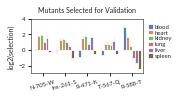

In [27]:
validation_set = [(705.0, 'W', 0, 'sub'),
          (261.5, 'S', 0, 'ins'),
          (471.0, 'K', 0, 'sub'),
          (567.0, 'Q', 0, 'sub'),
          (588.0, 'T', 0, 'sub'),
         (588, 'T',0,'sub')
          ]

df = pd.DataFrame()
mutant_list=[]
for mut in  validation_set:
#     print mut
    if mut[3] == 'sub':
        wt_res = LOOKUP_DF[(LOOKUP_DF['abs_pos']==mut[0]) & (LOOKUP_DF['is_wt_aa']==1)]['aa'].values[0]
#         print wt_res
    else:
        wt_res = mut[3]
    df = pd.concat([df, mouse_aa_selection.xs(mut, level=['abs_pos', 'aa','wt_bc', 'lib_type'], drop_level=False)])
    mutant_add = list(mut)
    mutant_add.insert(0, wt_res)
    mutant_list.append(tuple(mutant_add))

df_tidy = tidy_mouse_df(df)
fig = plt.figure(figsize=[2,1])
g = sns.barplot(x='aa_gene', y=0, hue='organ',errwidth=.1,  data=df_tidy, 
            dodge=True, hue_order=tissue_grabber,palette = sns.color_palette("muted", 10) )
g.set_title('Mutants Selected for Validation')
g.set_ylabel('log2(selection)')
g.set(ylim=(-3,4))
g.set_xticklabels(['%s-%s-%s' % (x[0],int(x[1]),x[2]) for x in mutant_list], rotation = 15)
plt.legend(frameon=False,bbox_to_anchor=[1,1],handlelength=.8,labelspacing=.1,handletextpad=.2)
plt.xlabel('')

In [28]:
for x in mutant_list:
    print ('%s-%s-%s' % (x[0],int(x[1]),x[2]))

N-705-W
ins-261-S
R-471-K
T-567-Q
R-588-T
R-588-T


In [29]:
validation_df = common.construct_validation_qPCR_df()

/home/ubuntu/repos/AAV_fitness_landscape/x02_analysis/common.py:176: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  all_data = pd.concat([data_2_merge, data_merge])


In [30]:
validation_df.head()

,aa,abs_pos,codon,lib_type,pEK,wt_aa,index,tissue,biological,FAM_tissue,HEX_tissue,log2-selection_tissue,HEX_virus,FAM_virus,log2-selection_virus,organ,selection_virus_tissue
0,T,588.0,act,sub,212,R,58,H,a,25.488133,27.295514,-1.807381,17.314752,17.217971,-0.096781,heart,1.710600
1,T,588.0,act,sub,212,R,59,H,b,26.016722,27.988104,-1.971382,17.314752,17.217971,-0.096781,heart,1.874601
2,T,588.0,act,sub,212,R,60,H,c,25.260015,27.707480,-2.447465,17.314752,17.217971,-0.096781,heart,2.350683
3,T,588.0,act,sub,212,R,61,K,a,24.805328,26.669068,-1.863741,17.314752,17.217971,-0.096781,kidney,1.766959
4,T,588.0,act,sub,212,R,62,K,b,24.511344,26.979276,-2.467933,17.314752,17.217971,-0.096781,kidney,2.371151


In [31]:
validation_df = common.construct_validation_qPCR_df()
validation_df.drop(index=192,inplace=True)
validation_df.head()
library_mutant_validation_selection = df_tidy.groupby(
    ['abs_pos', 'aa','organ'])[0].aggregate(['median','mean'])
pcr_mutant_validation_selection = validation_df.groupby(
    ['abs_pos','aa','organ','biological' ])['selection_virus_tissue'].aggregate(['median','mean'])
val_lib_joined = pcr_mutant_validation_selection.reset_index().merge(
    library_mutant_validation_selection.reset_index(),on=['abs_pos', 'aa', 'organ'], suffixes=('_val', '_lib'))

In [32]:
stats.pearsonr(val_lib_joined['median_lib'], val_lib_joined['median_val'])

(0.75471231777608061, 1.9119182542815268e-14)

### compare validation selection to selection in library

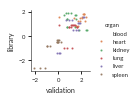

In [33]:
height=1.5
s=5
markers = ['.','.','.','.','.','.']
g = sns.lmplot('median_val', 'median_lib',val_lib_joined, hue='organ',hue_order=tissue_grabber,markers=markers,
           fit_reg=False,scatter_kws={'s':5,'alpha':.8},line_kws={'color':'gray'}, height=height)
g.set_axis_labels('validation', 'library')
